# Filtering with a Benes--Bernoulli model

In this notebook, let's see implement the moment filter for the model

$$
\begin{equation}
    \begin{split}
        \mathrm{d} X(t) &= \tanh(X(t)) \mathrm{d} t + \mathrm{d} W(t), \\
        X(0) &\sim \frac{1}{2}\bigl( \mathcal{N}(-0.5, 0.05) + \mathcal{N}(0.5, 0.05)\bigr), \\
        Y_k \mid X_k &\sim \mathrm{Bernoulli}\biggl(\frac{1}{1 + \exp(-X_k^3 \, / \, 5)}\biggr),
    \end{split}
\end{equation}
$$

the solution of which is non-Gaussian and non-unimodal.

The mode of moments used in this notebook is raw. If you want to see how to use other moment modes (e.g., central or scaled), see the notebook `sdf`.

# Import

First, import necessary packages.

In [11]:
import jax
import jax.numpy as jnp
import tme.base_jax as tme
import matplotlib.pyplot as plt
from mfs.one_dim.filtering import moment_filter_rms
from mfs.one_dim.moments import raw_moment_of_normal
from mfs.utils import GaussianSum1D, simulate_sde
from jax.config import config
from functools import partial

# Using `float64` is often necessary.
config.update("jax_enable_x64", True)

# Random seed
key = jax.random.PRNGKey(666)

# Define the model

Let us define the model first, and simulate a trajectory and measurements.

In [12]:
def drift(x):
    """Drift function
    """
    return jnp.tanh(x)


def dispersion(_):
    """Dispersion function
    """
    return 1.


def logistic(x):
    return 1 / (1 + jnp.exp(-x ** 3 / 5))


# The order which gives to 2 * N - 1 moments. The higher the more accurate.
N = 10

# Initial condition
init_cond = GaussianSum1D.new(means=jnp.array([-0.5, 0.5]),
                              variances=jnp.array([0.05, 0.05]),
                              weights=jnp.array([0.5, 0.5]),
                              N=N)

# Random keys for simulation
key_x0, key_xs, key_ys = jax.random.split(key, 3)

# Times
dt = 1e-2
T = 100
ts = jnp.linspace(dt, dt * T, T)

# Simulate an initial, a trajectory, and measurements
x0 = init_cond.sampler(key_x0, 1)[0]
xs = simulate_sde(lambda _x, _dt: tme.mean_and_cov(jnp.atleast_1d(_x), _dt, drift, dispersion, order=3),
                  x0, dt, T, key_xs, diagonal_cov=False, integration_steps=100)[:, 0]
ys = jax.random.bernoulli(key_ys, logistic(xs), (T,))

To do the moment filtering, we need to know

- the transition moments $\mathbb{E}[X_k^n \mid X_{k-1}]$ for any $n$,
- and the likelihood probability density function $p(y \mid x)$.

The likelihood density function is that of the Bernoulli which is already known. The tricky part is how to have a good approximation to the transition moment. Please see the paper to see how to do so.

To expose the idea, let's use the simplest Euler--Maruyama.

In [13]:
def measurement_cond_pmf(y, x):
    """p(y | x)
    """
    return jax.scipy.stats.bernoulli.pmf(y, logistic(x))


@partial(jax.vmap, in_axes=[0, None])
@partial(jax.vmap, in_axes=[None, 0])
def state_cond_raw_moments_euler_maruyama(x, n):
    """This computes E[X_k^n | X_{k-1} = x], and using vmap can vectorise over x and n.

    Note: this implementation is not efficient, since vmap does not really will vectorise over n.
    """
    cond_mean, cond_var = x + drift(x) * dt, dispersion(x) ** 2
    return jnp.array([raw_moment_of_normal(jnp.squeeze(cond_mean), jnp.squeeze(cond_var), p)
                      for p in range(2 * N)])[n]


@partial(jax.vmap, in_axes=[0, None])
@partial(jax.vmap, in_axes=[None, 0])
def state_cond_raw_moments(x, n):
    """This is an alternative implementation to the Euler--Maruyama approach above.

    This is super efficient when you have large N, since it does vectorise over n.
    """

    def phi(u):
        return u ** n

    return jnp.squeeze(tme.expectation(phi, jnp.atleast_1d(x), dt, drift, dispersion, order=3))

# Moment filter

That's all! Now just call the filter and get the results.

In [14]:
@jax.jit
def moment_filter(_ys):
    return moment_filter_rms(state_cond_raw_moments, measurement_cond_pmf, init_cond.rms, _ys)

In [15]:
rmss, nell = moment_filter(ys)

# moments are ordered by [m0, m1, m2, .... m_{2 N - 1}]
means = rmss[:, 1]
variances = rmss[:, 2] - means ** 2

Plot the results!

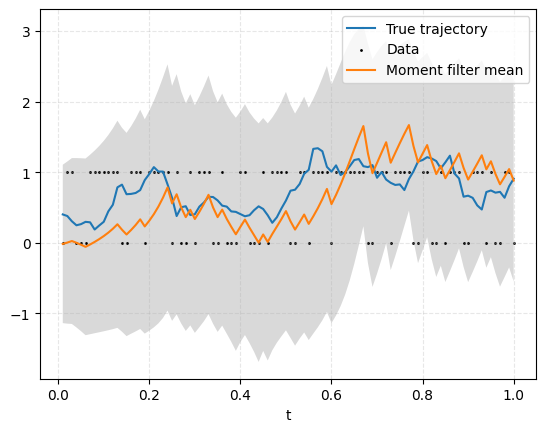

In [16]:
plt.plot(ts, xs, label='True trajectory')
plt.scatter(ts, ys, c='black', s=1, label='Data')
plt.plot(ts, means, label='Moment filter mean')
plt.fill_between(ts,
                 means - 2 * jnp.sqrt(variances),
                 means + 2 * jnp.sqrt(variances),
                 color='black',
                 edgecolor='none',
                 alpha=0.15)

_ = plt.legend()
plt.grid(linestyle='--', alpha=0.3, which='both')
_ = plt.xlabel('t')

# Moments
What to do with the moments in `rmss`? It's not fair to just plot the mean and variance as we did in the above.

The $2 N$ moments approximately represent the true distribution. You can

- Plot the quadrature nodes and weights generated by the moments `rmss`.
- Use the quadrature rules based on `rmss` to compute the characteristic function $z\mapsto\mathbb{E}[\exp(i \, z \, X)]$, then plot.
- Form a Gram--Charlier PDF approximation based on `rmss`, then plot the approximate PDF.
- ...

# Comparison

You can compare the results with extended Kalman filter, Gaussian filters, and particle filters etc. Please check the implementations in `./dardel` to see how we compared.

# Exercise

Try using `state_cond_raw_moments_euler_maruyama` instead of `state_cond_raw_moments`, see what will happen.

# Using other moment modes

Sometimes, we have to use other moment modes (e.g., central or scaled central) for numerical stability.

For example, to use central moments, we can do this:

In [17]:
from mfs.one_dim.filtering import moment_filter_cms


@partial(jax.vmap, in_axes=[0, None, None])
@partial(jax.vmap, in_axes=[None, 0, None])
def state_cond_central_moments(x, n, mean):
    """This computes the conditional central moment E[(X_k - mean)^n | X_{k-1} = x] by TME
    """

    def phi(u):
        return (u - mean) ** n

    return jnp.squeeze(tme.expectation(phi, jnp.atleast_1d(x), dt, drift, dispersion, order=3))


@partial(jax.vmap, in_axes=[0])
def state_cond_mean(x):
    """This computes the conditionam mean.
    """
    return jnp.squeeze(tme.expectation(lambda u: u, jnp.atleast_1d(x), dt, drift, dispersion, order=3))


@jax.jit
def moment_filter(_ys):
    return moment_filter_cms(state_cond_central_moments, state_cond_mean, measurement_cond_pmf, init_cond.cms,
                             init_cond.mean, _ys)

In [18]:
cmss, means2, nell2 = moment_filter(ys)

variances2 = cmss[:, 2]

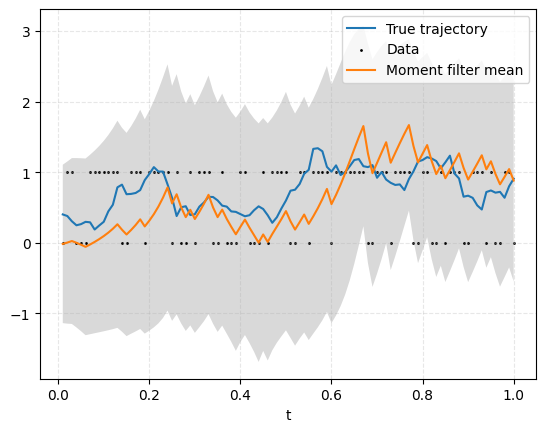

In [19]:
plt.plot(ts, xs, label='True trajectory')
plt.scatter(ts, ys, c='black', s=1, label='Data')
plt.plot(ts, means2, label='Moment filter mean')
plt.fill_between(ts,
                 means2 - 2 * jnp.sqrt(variances2),
                 means2 + 2 * jnp.sqrt(variances2),
                 color='black',
                 edgecolor='none',
                 alpha=0.15)

_ = plt.legend()
plt.grid(linestyle='--', alpha=0.3, which='both')
_ = plt.xlabel('t')

The results should be numerically the same as with using the raw moments.

In [20]:
# The difference between the means
jnp.sum(jnp.abs(means - means2))

Array(3.7690722e-11, dtype=float64)

In [21]:
# The difference between the log-likelihood
nell - nell2

Array(1.36424205e-12, dtype=float64)

# Exercise

In `mfs.one_dim.filtering` I have also implemented `moment_filter_scms` for using scaled central moments. Try this.